In [ ]:

%load_ext autoreload
%autoreload 2

import argparse
from sklearn import metrics
import comet_ml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
import warmup_scheduler
import numpy as np
import pandas as pd
from torchvision import transforms
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_model, get_dataset, get_experiment_name, get_criterion
from da import CutMix, MixUp
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
class Settings:
    def __init__(self):
        self.dataset = "siim"
        self.num_classes = 2
        self.model_name = "vit"
        self.patch = 8
        self.batch_size = 8
        self.eval_batch_size = 1024
        self.lr = 1e-3
        self.min_lr = 1e-5
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.max_epochs = 3
        self.weight_decay = 5e-5
        self.warmup_epoch = 5
        self.precision = 16
        self.criterion = "ce"
        self.smoothing = 0.1
        self.dropout = 0.0
        self.head = 12
        self.num_layers = 7
        self.hidden = 384
        self.label_smoothing = False
        self.mlp_hidden = 384
        self.seed = 42
        self.project_name = "VisionTransformer"
        self.off_benchmark = False
        self.dry_run = False
        self.autoaugment = False
        self.rcpaste = False
        self.cutmix = False
        self.mixup = False
        self.off_cls_token = False
        self.api_key = False

args = Settings()

torch.manual_seed(args.seed)
np.random.seed(args.seed)
args.benchmark = True if not args.off_benchmark else False
args.gpus = torch.cuda.device_count()
args.num_workers = 4*args.gpus if args.gpus else 8
args.is_cls_token = True if not args.off_cls_token else False
if not args.gpus:
    args.precision=32

if args.mlp_hidden != args.hidden*4:
    print(f"[INFO] In original paper, mlp_hidden(CURRENT:{args.mlp_hidden}) is set to: {args.hidden*4}(={args.hidden}*4)")


In [1]:

%load_ext autoreload
%autoreload 2

import argparse
from sklearn import metrics
#import comet_ml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
import warmup_scheduler
import numpy as np
import pandas as pd
from torchvision import transforms
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_model, get_dataset, get_experiment_name, get_criterion
from da import CutMix, MixUp
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from ham import HAM

In [2]:
import torch
from PIL import Image
from torchvision import transforms
#import torchvision
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
import math
from sklearn.model_selection import train_test_split

class HAM(Dataset):
    """HAM dataset class"""

    def __init__(self, root, purpose, seed, split, transforms=None, tfm_on_patch=None):
        self.root_path = root
        self.purpose = purpose
        self.seed = seed
        self.split = split
        self.img_part1 = os.listdir(f'{root}/HAM10000_images_part_1/')
        self.img_part2 = os.listdir(f'{root}/HAM10000_images_part_2/')
        self.images, self.labels = self._make_dataset(directory=self.root_path, purpose=self.purpose, seed=self.seed, split=self.split)
        self.transforms = transforms
        self.tfm_on_patch = tfm_on_patch

    def _make_dataset(self,directory, purpose, seed, split):
        """
        Create the image dataset by preparing a list of samples
        :param directory: root directory of the dataset
        :returns: (images, labels) where:
            - images is a numpy array containing all images in the dataset
            - labels is a list containing one label per image
        """

        data_path = os.path.join(directory, "HAM10000_metadata.csv")
        meta_df = pd.read_csv(data_path)
        # meta_df.rename(columns={'image_id': 'image_name'})
        meta_df['target'] = pd.Categorical(meta_df['dx']).codes
        no_of_classes = meta_df['target'].unique()
        print(f'No. of Class in HAM: {no_of_classes}')
        meta_df['image_name'] = meta_df.apply(lambda row: self.extract_path_img(directory,row.image_id), axis=1)

    
        #(33126, 8)
        
        train, val = train_test_split(meta_df, test_size=split, random_state=seed)
        #do we want to apply stratification here?
        # train, val, test = np.split(meta_df.sample(frac=1, random_state=seed), 
        #                                 [int(split*meta_df.shape[0]), int(((1.0-split)/2.0+split)*meta_df.shape[0])])

        #train -> 24844
        #val -> 8282
        # trueRows = train[train['target'] == 1] # 434
        # falseRows = train[train['target'] == 0] # 24410
        # # # print(len(trueRows))
        # # # print(f" = > {len(falseRows) - len(trueRows)}")
        # trueReplicas = pd.concat([trueRows]*(math.ceil(len(falseRows)/len(trueRows)))) # 434*57 = 24738

        print(train['target'])
        
        
        # oversampled = falseRows.append(trueReplicas[:len(falseRows) - len(trueRows)], ignore_index=True) # 24410 + 23976  = 48386
        ######################

        if purpose=='train':
            return train['image_name'].tolist(), train['target'].tolist()
        elif purpose=='val':
            return val['image_name'].tolist(), val['target'].tolist()
        elif purpose=='test':
            data_path = os.path.join(directory, "test.csv")
            test_df = pd.read_csv(data_path, sep=',')

            return test_df['image_name'].tolist(), []

    def extract_path_img(self,directory,x):
        file = x + '.jpg'
        
        if file in self.img_part1:
            
            return os.path.join(f'{directory}/HAM10000_images_part_1', file)
        
        elif file in self.img_part2:
            
            return os.path.join(f'{directory}/HAM10000_images_part_2', file)
    def __len__(self):
        """Return number of images in the dataset"""
        return(len(self.images))
        
    def get_labels(self): return self.labels

    def __getitem__(self, index):
        """
        Creates a dict of the data at the given index:
            {"image": <i-th image>,                                              #
             "label": <label of i-th image>} 
        """
        img_root = self.images[index]
        
        #img = Image.open(img_root)
        #trans = transforms.ToTensor()
        #img = trans(img)
        #img = torchvision.io.read_image(img_root)
        img = read_image(img_root)
        if self.transforms is not None:
            img = self.transforms(img)


        if self.labels[index] == 1:
            transformForReplicas = transforms.RandomChoice([
                transforms.RandomHorizontalFlip(), 
                transforms.RandomVerticalFlip(),
                transforms.RandomAutocontrast(),
                transforms.RandomAdjustSharpness(sharpness_factor=2),
                transforms.RandomEqualize()
            ])

            transformForReplicas2 = transforms.RandomChoice([
                transforms.ColorJitter(brightness=.5, hue=.3),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.RandomRotation(degrees=(0, 180)),
                transforms.RandomPosterize(bits=2),
                
            ])

            img = transformForReplicas(img)
            img = transformForReplicas2(img)
        img = img.float()
     
        if self.purpose == 'test':
            return img
        else:
            return img, self.labels[index]

In [11]:
def extract_path_img(directory,x):
    file = x + '.jpg'
        
    if file in os.listdir(f'{directory}/HAM10000_images_part_1/'):
            
        return os.path.join(f'{directory}/HAM10000_images_part_1', file)
        
    elif file in os.listdir(f'{directory}/HAM10000_images_part_2/'):
            
        return os.path.join(f'{directory}/HAM10000_images_part_2', file)

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math

In [18]:
base_path = "/Users/k.urbanczyk/Desktop/archive"
#train_ds = HAM(base_path, purpose='train', seed=42, split=0.25)


data_path = os.path.join(base_path, "HAM10000_metadata.csv")
meta_df = pd.read_csv(data_path)
# meta_df.rename(columns={'image_id': 'image_name'})
meta_df['target'] = pd.Categorical(meta_df['dx']).codes
no_of_classes = meta_df['target'].unique()
print(f'No. of Class in HAM: {no_of_classes}')
meta_df['image_name'] = meta_df.apply(lambda row: extract_path_img(base_path, row.image_id), axis=1)

    
#(33126, 8)
        
train, val = train_test_split(meta_df, test_size=0.8, random_state=42)
print(train['target'])


No. of Class in HAM: [2 5 3 4 6 1 0]
4219    5
9092    5
8016    5
3292    5
819     2
       ..
5734    5
5191    5
5390    5
860     2
7270    5
Name: target, Length: 2003, dtype: int8
5
0
1
2
3
4
5
6


In [27]:
most_popular_count = train['target'].value_counts().max()
most_popular_idx = train['target'].value_counts().idxmax()
oversampled = train[train['target'] == most_popular_idx]
print(most_popular_idx)
print(most_popular_count)
for i in range(0,7):
    if most_popular_idx != i:
        to_be_replicated = train[train['target'] == i]
        replicas = pd.concat([to_be_replicated]*(math.ceil(most_popular_count/len(to_be_replicated))))
        oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
print(oversampled['target'].value_counts())

5
1355
5    1355
3    1336
6    1329
0    1294
1    1248
4    1144
2    1131
Name: target, dtype: int64


/var/folders/s3/jrl64rw543d61yb108hw2jlr0000gn/T/ipykernel_32399/1755862149.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
/var/folders/s3/jrl64rw543d61yb108hw2jlr0000gn/T/ipykernel_32399/1755862149.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
/var/folders/s3/jrl64rw543d61yb108hw2jlr0000gn/T/ipykernel_32399/1755862149.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
/var/folders/s3/jrl64rw54

In [3]:
class HAM():
    """HAM dataset class"""

    def __init__(self, root, purpose, seed, split, transforms=None, tfm_on_patch=None):
        self.root_path = root
        self.purpose = purpose
        self.seed = seed
        self.split = split
        self.img_part1 = os.listdir(f'{root}/HAM10000_images_part_1/')
        self.img_part2 = os.listdir(f'{root}/HAM10000_images_part_2/')
        self.images, self.labels, self.most_popular_idx = self._make_dataset(directory=self.root_path, purpose=self.purpose, seed=self.seed, split=self.split)
        self.transforms = transforms
        self.tfm_on_patch = tfm_on_patch

    def _make_dataset(self,directory, purpose, seed, split):
        """
        Create the image dataset by preparing a list of samples
        :param directory: root directory of the dataset
        :returns: (images, labels) where:
            - images is a numpy array containing all images in the dataset
            - labels is a list containing one label per image
        """

        data_path = os.path.join(directory, "HAM10000_metadata.csv")
        meta_df = pd.read_csv(data_path)
        # meta_df.rename(columns={'image_id': 'image_name'})
        meta_df['target'] = pd.Categorical(meta_df['dx']).codes
        no_of_classes = meta_df['target'].unique()
        #print(f'No. of Class in HAM: {no_of_classes}')
        meta_df['image_name'] = meta_df.apply(lambda row: self.extract_path_img(directory,row.image_id), axis=1)

    
        #(33126, 8)
        
        train, val = train_test_split(meta_df, test_size=split, random_state=seed)
        #do we want to apply stratification here?
        # train, val, test = np.split(meta_df.sample(frac=1, random_state=seed), 
        #                                 [int(split*meta_df.shape[0]), int(((1.0-split)/2.0+split)*meta_df.shape[0])])

        #train -> 24844
        #val -> 8282
        # trueRows = train[train['target'] == 1] # 434
        # falseRows = train[train['target'] == 0] # 24410
        # # # print(len(trueRows))
        # # # print(f" = > {len(falseRows) - len(trueRows)}")
        # trueReplicas = pd.concat([trueRows]*(math.ceil(len(falseRows)/len(trueRows)))) # 434*57 = 24738

        #print(train['target'])
        most_popular_count = train['target'].value_counts().max()
        most_popular_idx = train['target'].value_counts().idxmax()
        oversampled = train[train['target'] == most_popular_idx]
        #print(most_popular_idx)
        #print(most_popular_count)
        for i in range(0,7):
            if most_popular_idx != i:
                to_be_replicated = train[train['target'] == i]
                replicas = pd.concat([to_be_replicated]*(math.ceil(most_popular_count/len(to_be_replicated))))
                oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
        #print(oversampled['target'].value_counts())
        
        # oversampled = falseRows.append(trueReplicas[:len(falseRows) - len(trueRows)], ignore_index=True) # 24410 + 23976  = 48386
        ######################

        if purpose=='train':
            return oversampled['image_name'].tolist(), oversampled['target'].tolist(), most_popular_idx
        elif purpose=='val':
            return val['image_name'].tolist(), val['target'].tolist(), most_popular_idx
        elif purpose=='test':
            data_path = os.path.join(directory, "test.csv")
            test_df = pd.read_csv(data_path, sep=',')

            return test_df['image_name'].tolist(), [], most_popular_idx

    def extract_path_img(self,directory,x):
        file = x + '.jpg'
        
        if file in self.img_part1:
            
            return os.path.join(f'{directory}/HAM10000_images_part_1', file)
        
        elif file in self.img_part2:
            
            return os.path.join(f'{directory}/HAM10000_images_part_2', file)
    def __len__(self):
        """Return number of images in the dataset"""
        return(len(self.images))
        
    def get_labels(self): return self.labels

    def __getitem__(self, index):
        """
        Creates a dict of the data at the given index:
            {"image": <i-th image>,                                              #
             "label": <label of i-th image>} 
        """
        img_root = self.images[index]
        
        #img = Image.open(img_root)
        #trans = transforms.ToTensor()
        #img = trans(img)
        #img = torchvision.io.read_image(img_root)
        img = read_image(img_root)
        if self.transforms is not None:
            img = self.transforms(img)


        if self.labels[index] != self.most_popular_idx:
            transformForReplicas = transforms.RandomChoice([
                transforms.RandomHorizontalFlip(), 
                transforms.RandomVerticalFlip(),
                transforms.RandomAutocontrast(),
                transforms.RandomAdjustSharpness(sharpness_factor=2),
                transforms.RandomEqualize()
            ])

            transformForReplicas2 = transforms.RandomChoice([
                transforms.ColorJitter(brightness=.5, hue=.3),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.RandomRotation(degrees=(0, 180)),
                transforms.RandomPosterize(bits=2),
                
            ])

            img = transformForReplicas(img)
            img = transformForReplicas2(img)
        img = img.float()
     
        if self.purpose == 'test':
            return img
        else:
            return img, self.labels[index]

In [7]:
base_path = "/Users/k.urbanczyk/Desktop/archive"
train_ds = HAM(base_path, purpose='train', seed=42, split=0.25)

/var/folders/s3/jrl64rw543d61yb108hw2jlr0000gn/T/ipykernel_47284/2581524604.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
/var/folders/s3/jrl64rw543d61yb108hw2jlr0000gn/T/ipykernel_47284/2581524604.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
/var/folders/s3/jrl64rw543d61yb108hw2jlr0000gn/T/ipykernel_47284/2581524604.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled = oversampled.append(replicas[:most_popular_count - len(to_be_replicated)], ignore_index=True)
/var/folders/s3/jrl64rw54

In [73]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [97]:
N_classes = 1
N_per_class=100
label = np.concatenate([[i]*N_per_class for i in range(N_classes)])
out = np.stack([np.random.uniform(0,1,N_per_class*N_classes) for _ in range(N_classes)]).T
out /= out.sum(1,keepdims=True) #approximate softmax

/Users/k.urbanczyk/opt/miniconda3/envs/cenv-vit-siim/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

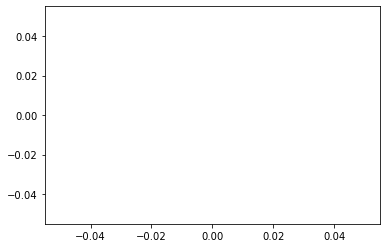

In [98]:
plot_multiclass_auc(out, label)

In [94]:
def plot_multiclass_auc(out,label, text="AUC Curve"):
    tpr,fpr,roc_auc = ([[]]*7 for _ in range(3))
    f,ax = plt.subplots()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(label==i, out[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax.plot(fpr[i],tpr[i])
        f1 = f1_score(torch.tensor(label), torch.argmax(torch.tensor(out), dim=1), average ='micro')
    plt.legend(['Class {:d}, AUC {}'.format(d, round(roc_auc[d],3)) for d in range(7)])
    plt.title('{}, {}, F1-Score: {})'.format(text,"gunwo", f1))
    plt.xlabel('FPR')
    plt.ylabel('TPR')

In [46]:
a= roc_curve(label==1, out[:, 1])

In [82]:
import torch

In [113]:
out2 = torch.round(torch.tensor(out))
label2 = torch.tensor(label)


In [91]:
f1_score(label2, out2, average ='micro')

0.12857142857142856

In [116]:
f1_score(label, out2)

0.0

In [119]:
out2

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [ ]:
roc_curve(label==i, out[:, i])

In [33]:
roc_auc[0]

TypeError: 'generator' object is not subscriptable

In [ ]:
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.train_labels[idx].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
train_ds, test_ds = get_dataset(args)
# classes = torch.tensor([0, 1, 2])
# indices = (torch.tensor(train_ds.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
# train_ds = torch.utils.data.Subset(train_ds, indices)
# test_ds = torch.utils.data.Subset(test_ds, indices)
#print(data.shape)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)#, num_workers=args.num_workers, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=args.eval_batch_size, num_workers=args.num_workers, pin_memory=True)

In [ ]:
from torchsampler import ImbalancedDatasetSampler

train_loader = torch.utils.data.DataLoader(
    train_ds, 
    sampler=ImbalancedDatasetSampler(train_ds),
    batch_size=args.batch_size,
)

In [ ]:
next(iter(train_loader))

In [ ]:
ex = next(iter(train_loader))

In [ ]:
applier = transforms.RandomApply(transforms=[transforms.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = applier(train_ds[0][0])
plt.imshow((train_ds[4][0].permute(1, 2, 0)).numpy().astype(np.uint8))
plt.show()

In [ ]:
plot_it_somehow = train_ds[1][0]

# img = plot_it_somehow.swapaxes(0, 1)
# img = img.swapaxes(1, 2)

import matplotlib.pyplot as plt

plt.imshow((plot_it_somehow.permute(1, 2, 0)).numpy().astype(np.uint8))
plt.show()

from PIL import Image


# pil_image=Image.fromarray(plot_it_somehow.permute(1, 2, 0).numpy().astype(np.uint8))
# pil_image.show()




In [ ]:
import torchvision

# sample input (10 RGB images containing just Gaussian Noise)
batch_tensor = ex[0]   # (N, C, H, W)

# make grid (2 rows and 5 columns) to display our 10 images
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)

grid_img.shape
plt.imshow((grid_img.permute(1, 2, 0)).numpy().astype(np.uint8))
plt.show()

In [ ]:
class Net(pl.LightningModule):
    def __init__(self, hparams):
        super(Net, self).__init__()
        # self.hparams = hparams
        self.hparams.update(vars(hparams))
        self.model = get_model(hparams)
        self.criterion = get_criterion(args)
        if hparams.cutmix:
            self.cutmix = CutMix(hparams.size, beta=1.)
        if hparams.mixup:
            self.mixup = MixUp(alpha=1.)
        self.log_image_flag = hparams.api_key is None

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, self.hparams.beta2), weight_decay=self.hparams.weight_decay)
        self.base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.min_lr)
        self.scheduler = warmup_scheduler.GradualWarmupScheduler(self.optimizer, multiplier=1., total_epoch=self.hparams.warmup_epoch, after_scheduler=self.base_scheduler)
        return [self.optimizer], [self.scheduler]

    def training_step(self, batch, batch_idx):
        img, label = batch
        if self.hparams.cutmix or self.hparams.mixup:
            if self.hparams.cutmix:
                img, label, rand_label, lambda_= self.cutmix((img, label))
            elif self.hparams.mixup:
                if np.random.rand() <= 0.8:
                    img, label, rand_label, lambda_ = self.mixup((img, label))
                else:
                    img, label, rand_label, lambda_ = img, label, torch.zeros_like(label), 1.
            out = self.model(img)
            loss = self.criterion(out, label)*lambda_ + self.criterion(out, rand_label)*(1.-lambda_)
        else:
            out = self(img)
            loss = self.criterion(out[:,1], label.float())

        if not self.log_image_flag and not self.hparams.dry_run:
            self.log_image_flag = True
            #self._log_image(img.clone().detach().cpu())

        acc = torch.eq(out.argmax(-1), label).float().mean()
        auc_score = metrics.roc_auc_score(label, out[:, 1].squeeze().detach().numpy())
        self.log('auc', auc_score, on_step=True, on_epoch=True)
        self.log('acc', acc, on_step=True, on_epoch=True)
        self.log('loss', loss,on_step=True, on_epoch=True)
        return loss

    def training_epoch_end(self, outputs):
        #self.log("lr", self.optimizer.param_groups[0]["lr"], on_epoch=self.current_epoch)
        self.log("lr", self.optimizer.param_groups[0]["lr"])

    def validation_step(self, batch, batch_idx):
        img, label = batch
        out = self(img)
        loss = self.criterion(out[:,1], label.float())
        acc = torch.eq(out.argmax(-1), label).float().mean()
        #self.log("val_loss", loss)
        #self.log("val_acc", acc)

        auc_score = metrics.roc_auc_score(label.cpu(), out[:, 1].squeeze())
        self.log('auc', auc_score, on_step=True, on_epoch=True)
        val_acc = torchmetrics.functional.accuracy(out[:, 1], label)
        self.log('valid_acc_from_tmet', val_acc, on_step=True, on_epoch=True)
        self.log('valid_acc', acc, on_step=True, on_epoch=True)
        self.log('val_loss', loss,on_step=True, on_epoch=True)

        # fpr, tpr, thresholds = roc_curve(label, out[:, 1])
        # auc_rf = auc(fpr, tpr)
        # plt.figure(1)
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.plot(fpr, tpr, label='Vit (area = {:.3f})'.format(auc_rf))
        # plt.xlabel('False positive rate')
        # plt.ylabel('True positive rate')
        # plt.title('ROC curve')
        # plt.legend(loc='best')
        # self.logger.experiment.add_figure('AUC Curve', plt.gcf(), self.current_epoch)

        return { 'loss': loss.item(), 'preds': out, 'target': label}

    def validation_epoch_end(self, outputs):
        preds = torch.cat([tmp['preds'] for tmp in outputs])
        targets = torch.cat([tmp['target'] for tmp in outputs])
        confusion_matrix = torchmetrics.functional.confusion_matrix(preds, targets, num_classes=args.num_classes)

        df_cm = pd.DataFrame(confusion_matrix.cpu().numpy(), index = range(args.num_classes), columns=range(args.num_classes))
        plt.figure(figsize = (args.num_classes,args.num_classes*2))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        
        #self.logger.experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

        # fpr, tpr, thresholds = roc_curve(targets, preds[:, 1])
        # auc_rf = auc(fpr, tpr)
        # plt.figure(1)
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.plot(fpr, tpr, label='Vit (area = {:.3f})'.format(auc_rf))
        # plt.xlabel('False positive rate')
        # plt.ylabel('True positive rate')
        # plt.title('ROC/AUC curve')
        # plt.legend(loc='best')
        # self.logger.experiment.add_figure('ROC/AUC Curve', plt.gcf(), self.current_epoch)

        # repo_root = os.path.abspath(os.getcwd())
        # data_root = os.path.join(repo_root, "logs")
        # list_of_files = glob.glob(f'{data_root}/*') # * means all if need specific format then *.csv
        # latest_file = max(list_of_files, key=os.path.getctime)
        # writer = SummaryWriter(latest_file)
        # writer.add_figure("Confusion matrix", fig_, self.current_epoch)

    # def _log_image(self, image):
    #     grid = torchvision.utils.make_grid(image, nrow=4)
    #     self.logger.experiment.log_image(grid.permute(1,2,0))
    #     print("[INFO] LOG IMAGE!!!")

In [ ]:
experiment_name = get_experiment_name(args)
if args.api_key:
    print("[INFO] Log with Comet.ml!")
    logger = pl.loggers.CometLogger(
        api_key=args.api_key,
        save_dir="logs",
        project_name=args.project_name,
        experiment_name=experiment_name
    )
    refresh_rate = 0
else:
    print("[INFO] Log with CSV")
    logger = pl.loggers.CSVLogger(
        save_dir="logs",
        name=experiment_name
    )
    #logger = TensorBoardLogger(name="vit_siim",save_dir="logs")
    refresh_rate = 1
args.model_name = 'vit'
args.experiment_name = 'vit_siim'    
net = Net(args)
trainer = pl.Trainer(precision=args.precision,fast_dev_run=args.dry_run, gpus=args.gpus, benchmark=args.benchmark,logger=logger, max_epochs=args.max_epochs)
trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=test_dl)
if not args.dry_run:
    model_path = f"weights/{experiment_name}.pth"
    torch.save(net.state_dict(), model_path)
    if args.api_key:
        logger.experiment.log_asset(file_name=experiment_name, file_data=model_path)


In [ ]:
import os
from siim import SIIM
import torchvision.transforms as transforms
df_test = pd.read_csv(os.path.join('D:/Workspace/cv_attention/data/siim', 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join('data/siim', 'test', f'{x}.jpg'))
n_test = 8
# repo_root = os.path.abspath(os.getcwd())
# data_root = os.path.join(repo_root, "data/siim")
data_root = "D:/Workspace/cv_attention/data/siim"
test_transform = []
if args.dataset == 'siim': 
        test_transform += [transforms.Resize(size=(32, 32))]
test_transform = transforms.Compose(test_transform)

test_ds = SIIM(data_root, purpose='test', seed=args.seed, split=0.7, transforms=test_transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=args.batch_size, num_workers=args.num_workers)

In [ ]:
from tqdm.notebook import tqdm
OUTPUTS = []


model = net
model.load_state_dict(torch.load(os.path.join('weights/vit_siim.pth')), strict=True)
model.eval()

LOGITS = []
PROBS = []

with torch.no_grad():
    for (data) in tqdm(test_loader):         
        data = data#.to(device)
        logits = torch.zeros((data.shape[0], 2))#.to(device)
        probs = torch.zeros((data.shape[0], 2))#.to(device)
        for I in range(n_test):
            l = model(data)
            logits += l
            probs += l.softmax(1)
        logits /= n_test
        probs /= n_test

        LOGITS.append(logits.detach().cpu())
        PROBS.append(probs.detach().cpu())

LOGITS = torch.cat(LOGITS).numpy()
PROBS = torch.cat(PROBS).numpy()

OUTPUTS.append(PROBS[:, 1])

In [ ]:
pred = np.zeros(OUTPUTS[0].shape[0])
for probs in OUTPUTS:
    pred += pd.Series(probs).rank(pct=True).values
pred /= len(OUTPUTS)

In [ ]:
# df_test['target'] = pred
# df_test[['image_name', 'target']].to_csv(f'submission.csv', index=False)
pred

In [ ]:
experiment_name = get_experiment_name(args)
if args.api_key:
    print("[INFO] Log with Comet.ml!")
    logger = pl.loggers.CometLogger(
        api_key=args.api_key,
        save_dir="logs",
        project_name=args.project_name,
        experiment_name=experiment_name
    )
    refresh_rate = 0
else:
    print("[INFO] Log with CSV")
    logger = pl.loggers.CSVLogger(
        save_dir="logs",
        name=experiment_name
    )
    #logger = TensorBoardLogger(name="vit_siim",save_dir="logs")
    refresh_rate = 1
args.model_name = 'cnn'
args.experiment_name = 'cnn_siim'
net = Net(args)
trainer = pl.Trainer(precision=args.precision,fast_dev_run=args.dry_run, gpus=args.gpus, benchmark=args.benchmark,logger=logger, max_epochs=args.max_epochs)
trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=test_dl)
if not args.dry_run:
    model_path = f"weights/{args.experiment_name}.pth"
    torch.save(net.state_dict(), model_path)
    if args.api_key:
        logger.experiment.log_asset(file_name=args.experiment_name, file_data=model_path)

In [ ]:
experiment_name = get_experiment_name(args)
if args.api_key:
    print("[INFO] Log with Comet.ml!")
    logger = pl.loggers.CometLogger(
        api_key=args.api_key,
        save_dir="logs",
        project_name=args.project_name,
        experiment_name=experiment_name
    )
    refresh_rate = 0
else:
    print("[INFO] Log with CSV")
    logger = pl.loggers.CSVLogger(
        save_dir="logs",
        name=experiment_name
    )
    #logger = TensorBoardLogger(name="vit_siim",save_dir="logs")
    refresh_rate = 1
args.model_name = 'vit_emb'
args.experiment_name = 'vit_emb_siim'
net = Net(args)
trainer = pl.Trainer(precision=args.precision,fast_dev_run=args.dry_run, gpus=args.gpus, benchmark=args.benchmark,logger=logger, max_epochs=args.max_epochs)
trainer.fit(model=net, train_dataloader=train_dl, val_dataloaders=test_dl)
if not args.dry_run:
    model_path = f"weights/{args.experiment_name}.pth"
    torch.save(net.state_dict(), model_path)
    if args.api_key:
        logger.experiment.log_asset(file_name=args.experiment_name, file_data=model_path)

In [ ]:

model = Net(args)
model.load_state_dict(torch.load(os.path.join('weights/vit_siim.pth')), strict=True)
model.eval()

In [ ]:

%load_ext autoreload
%autoreload 2
from vit_embedded import ViTEmbedded
#newmodel = model.model.feature_extractor
ex = ViTEmbedded(64, 
            2, 
            img_size=8, 
            patch=8, 
            dropout=args.dropout, 
            mlp_hidden=args.mlp_hidden,
            num_layers=args.num_layers,
            hidden=args.hidden,
            head=args.head,
            is_cls_token=args.is_cls_token)

dl = next(iter(train_dl))

ex.forward(dl[0])

In [ ]:

%load_ext autoreload
%autoreload 2
import torchvision.models as models
res = models.resnet18(pretrained=False)
res = nn.Sequential(*list(res.children())[:-4])
d = res.forward(dl[0])
d.shape
res

In [ ]:
dl[0].shape

In [ ]:
import torchvision.models as models
#mo = models.resnet18(pretrained=False)
model.model.classifier = model.model.feature_extractor
print(model.model.classifier)

In [ ]:
from model.attention.CoAtNet import CoAtNet
import torch
from torch import nn
from torch.nn import functional as F

input=torch.randn(1,3,224,224)
mbconv=CoAtNet(in_ch=3,image_size=224)
out=mbconv(input)
print(out.shape)

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
#import torchvision
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
import math
from sklearn.model_selection import train_test_split
class HAM(Dataset):
    """HAM dataset class"""

    def __init__(self, root, purpose, seed, split, transforms=None, tfm_on_patch=None):
        self.root_path = root
        self.purpose = purpose
        self.seed = seed
        self.split = split
        self.img_part1 = os.listdir(f'{root}/HAM10000_images_part_1/')
        self.img_part2 = os.listdir(f'{root}/HAM10000_images_part_2/')
        self.images, self.labels = self._make_dataset(directory=self.root_path, purpose=self.purpose, seed=self.seed, split=self.split)
        self.transforms = transforms
        self.tfm_on_patch = tfm_on_patch

    def _make_dataset(self,directory, purpose, seed, split):
        """
        Create the image dataset by preparing a list of samples
        :param directory: root directory of the dataset
        :returns: (images, labels) where:
            - images is a numpy array containing all images in the dataset
            - labels is a list containing one label per image
        """

        data_path = os.path.join(directory, "HAM10000_metadata.csv")
        meta_df = pd.read_csv(data_path)
        # meta_df.rename(columns={'image_id': 'image_name'})
        meta_df['target'] = pd.Categorical(meta_df['dx']).codes
        meta_df['image_name'] = meta_df.apply(lambda row: self.extract_path_img(directory,row.image_id), axis=1)

        
    
        #(33126, 8)
        
        train, val = train_test_split(meta_df, test_size=split, random_state=seed)
        #do we want to apply stratification here?
        # train, val, test = np.split(meta_df.sample(frac=1, random_state=seed), 
        #                                 [int(split*meta_df.shape[0]), int(((1.0-split)/2.0+split)*meta_df.shape[0])])

        #train -> 24844
        #val -> 8282
        # trueRows = train[train['target'] == 1] # 434
        # falseRows = train[train['target'] == 0] # 24410
        # # # print(len(trueRows))
        # # # print(f" = > {len(falseRows) - len(trueRows)}")
        # trueReplicas = pd.concat([trueRows]*(math.ceil(len(falseRows)/len(trueRows)))) # 434*57 = 24738


        
        
        # oversampled = falseRows.append(trueReplicas[:len(falseRows) - len(trueRows)], ignore_index=True) # 24410 + 23976  = 48386
        ######################

        if purpose=='train':
            return train['image_name'].tolist(), train['target'].tolist()
        elif purpose=='val':
            return val['image_name'].tolist(), val['target'].tolist()
        elif purpose=='test':
            data_path = os.path.join(directory, "test.csv")
            test_df = pd.read_csv(data_path, sep=',')

            return test_df['image_name'].tolist(), []

    def extract_path_img(self,directory,x):
        file = x + '.jpg'
        
        if file in self.img_part1:
            
            return os.path.join(f'{directory}/HAM10000_images_part_1', file)
        
        elif file in self.img_part2:
            
            return os.path.join(f'{directory}/HAM10000_images_part_2', file)
    def __len__(self):
        """Return number of images in the dataset"""
        return(len(self.images))
        
    def get_labels(self): return self.labels

    def __getitem__(self, index):
        """
        Creates a dict of the data at the given index:
            {"image": <i-th image>,                                              #
             "label": <label of i-th image>} 
        """

        img_root = self.images[index]
        
        #img = Image.open(img_root)
        #trans = transforms.ToTensor()
        #img = trans(img)
        #img = torchvision.io.read_image(img_root)
        img = read_image(img_root)
        if self.transforms is not None:
            img = self.transforms(img)


        if self.labels[index] == 1:
            transformForReplicas = transforms.RandomChoice([
                transforms.RandomHorizontalFlip(), 
                transforms.RandomVerticalFlip(),
                transforms.RandomAutocontrast(),
                transforms.RandomAdjustSharpness(sharpness_factor=2),
                transforms.RandomEqualize()
            ])

            transformForReplicas2 = transforms.RandomChoice([
                transforms.ColorJitter(brightness=.5, hue=.3),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.RandomRotation(degrees=(0, 180)),
                transforms.RandomPosterize(bits=2),
                
            ])

            img = transformForReplicas(img)
            img = transformForReplicas2(img)
        img = img.float()

        
        if self.purpose == 'test':
            return img
        else:
            return img, self.labels[index]
        return img, torch.tensor([self.labels[index]])


        data_dict = {
            'image': img,
            'label': torch.tensor([self.labels[index]])
        }

        


        # if self.tfm_on_patch is None: return data_dict

        # for tfm in self.tfm_on_patch:
        #     data_dict = tfm(data_dict)

        

        return data_dict

In [1]:

base_path = "/dss/dssmcmlfs01/pn69za/pn69za-dss-0002/ra49tad2/data/ham"
train_ds = HAM(base_path, purpose='train', seed=42, split=0.25)



# train, val = train_test_split(meta_df, test_size=split, random_state=seed)

NameError: name 'HAM' is not defined

In [ ]:
meta_df['cancer_idx'] = pd.Categorical(meta_df['dx']).codes
meta_df['image'][0]

In [ ]:
img_part1 = os.listdir(f'{base_path}/HAM10000_images_part_1/')
img_part2 = os.listdir(f'{base_path}/HAM10000_images_part_2/')